<a href="https://colab.research.google.com/github/chetverkin/cvr_course/blob/develop/notebooks/cv_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

## Чтение, подсчет и вид сверху

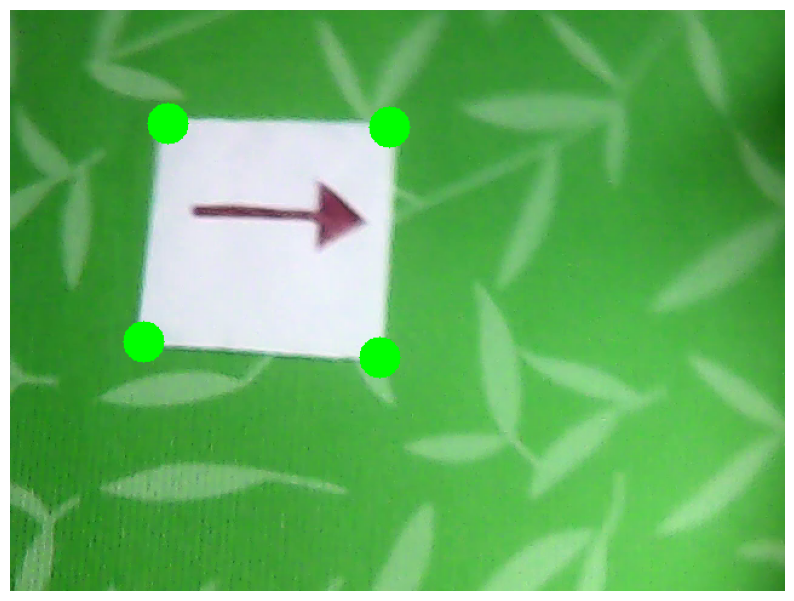

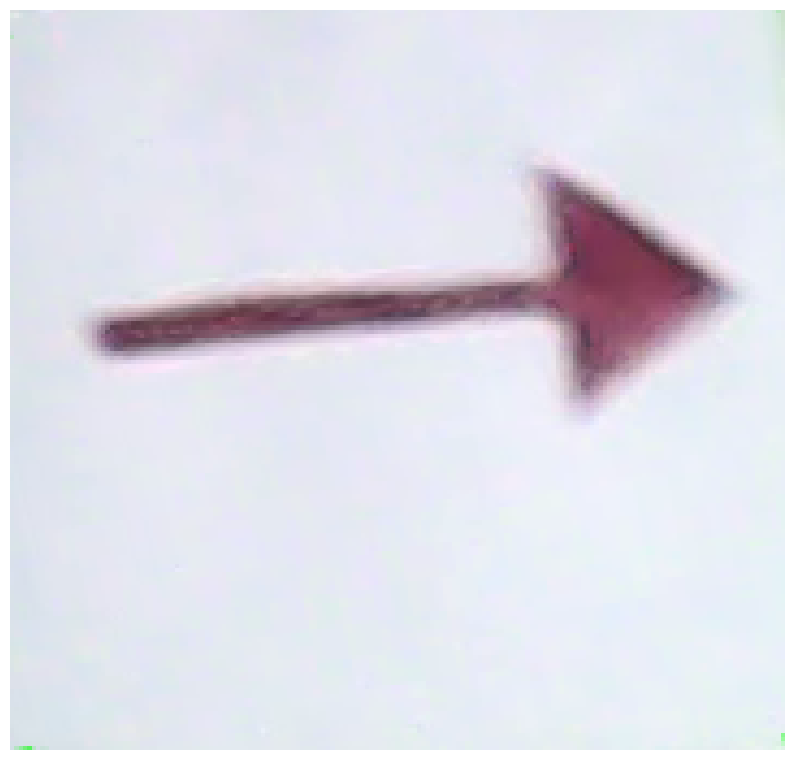

До листочка еще 87.39105589952386
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


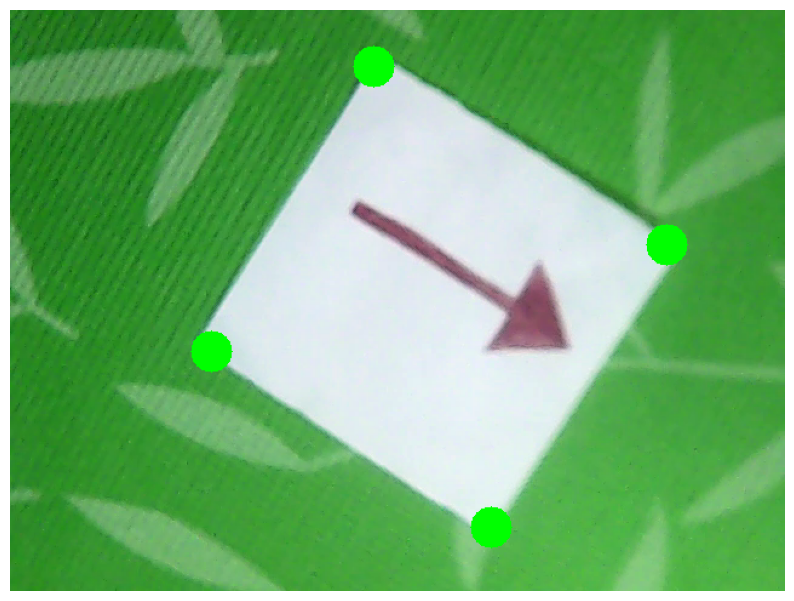

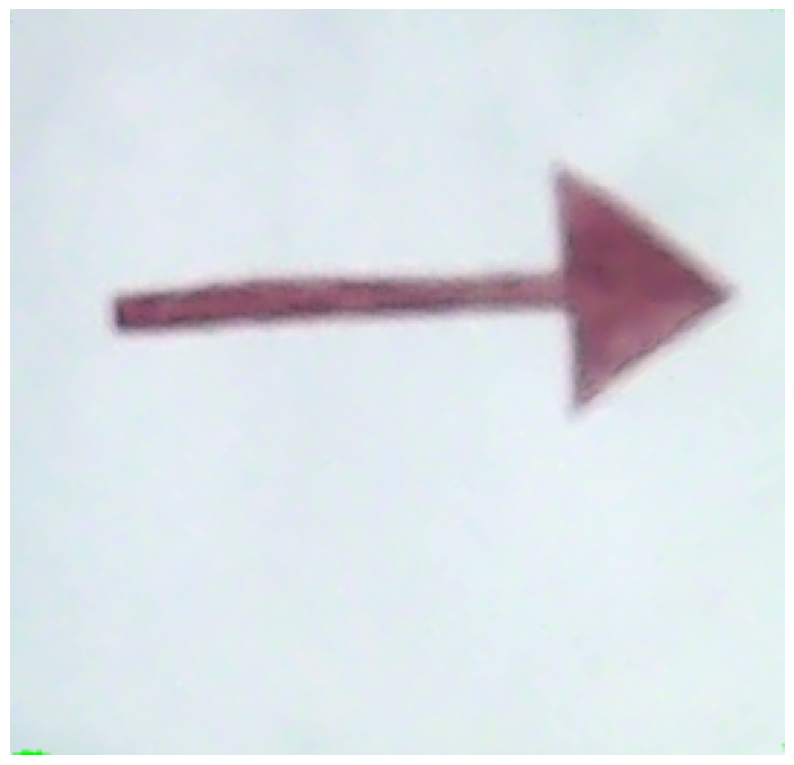

До листочка еще 59.518176410612334
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


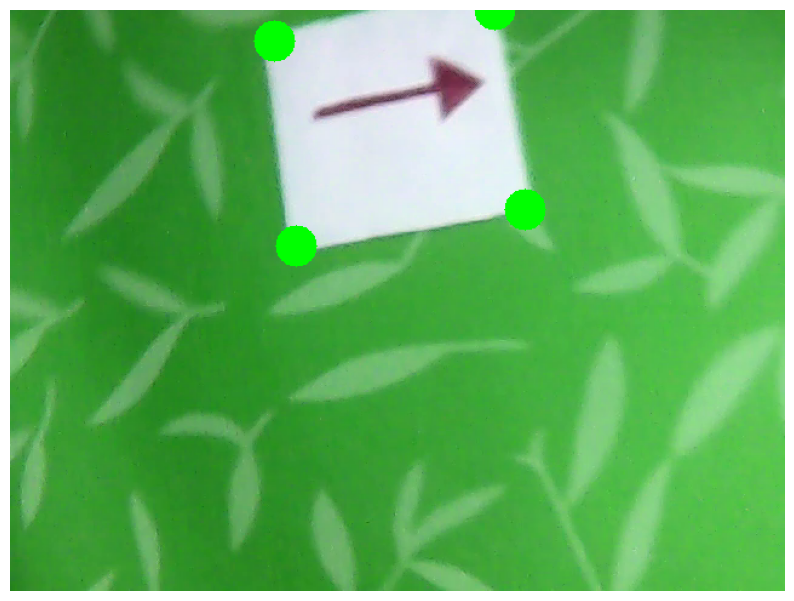

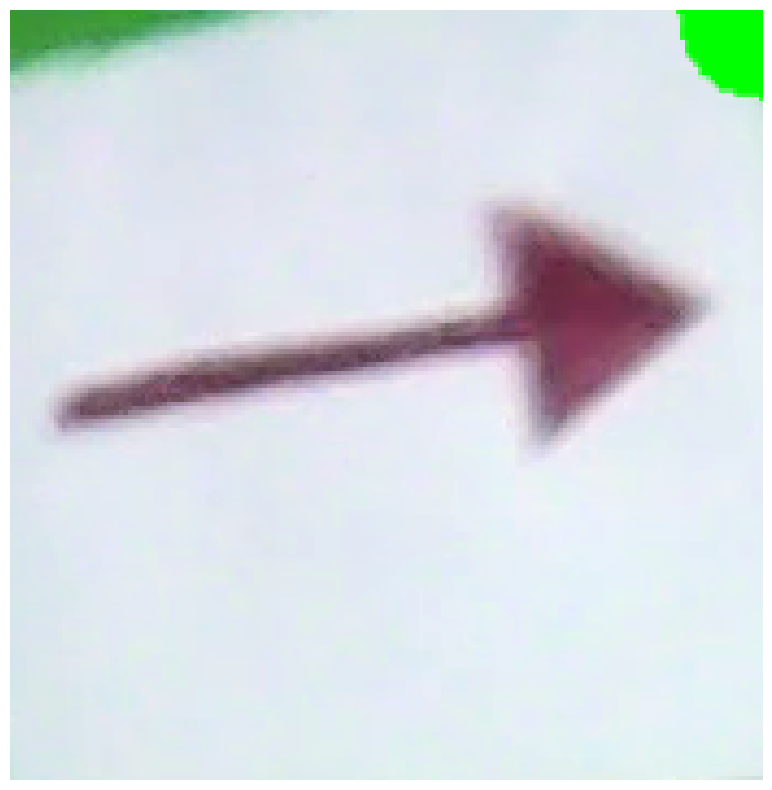

До листочка еще 92.01562718076504
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


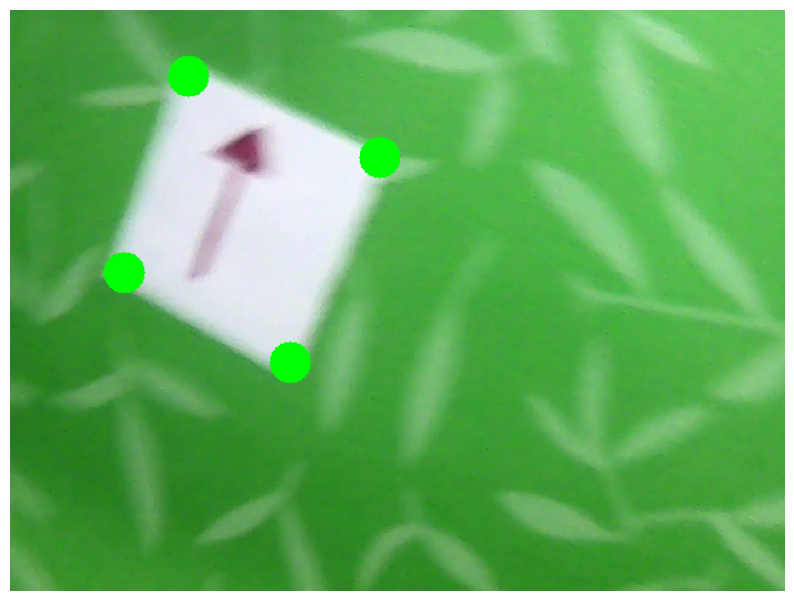

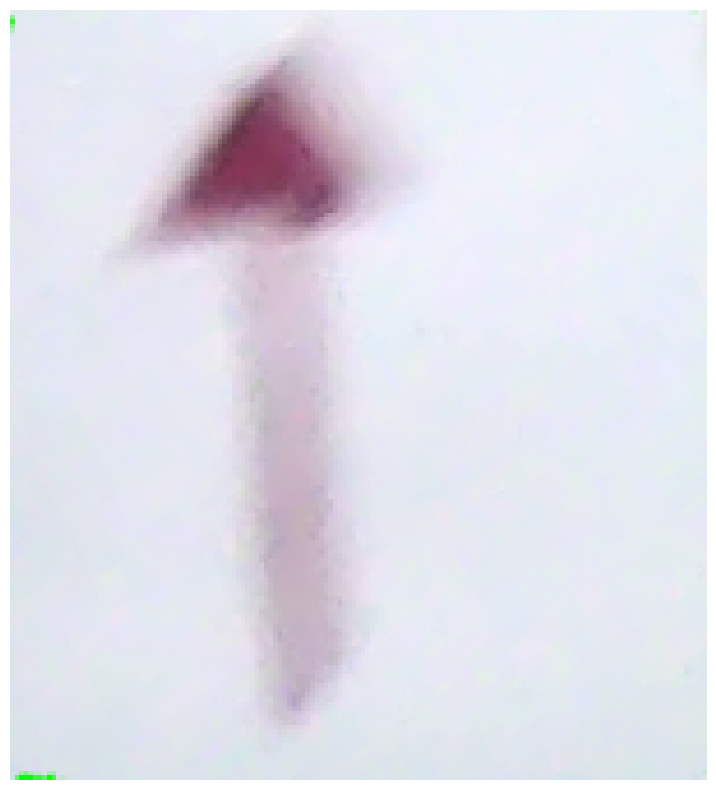

До листочка еще 96.03272706998
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


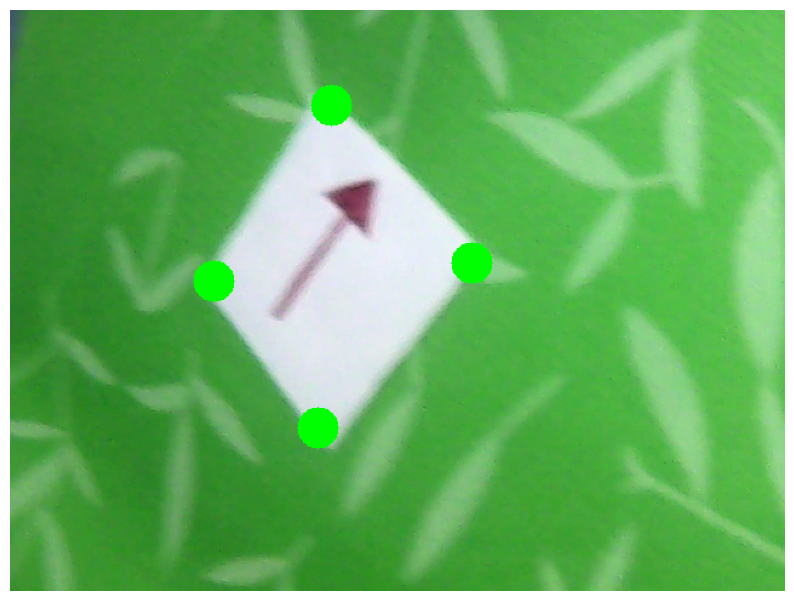

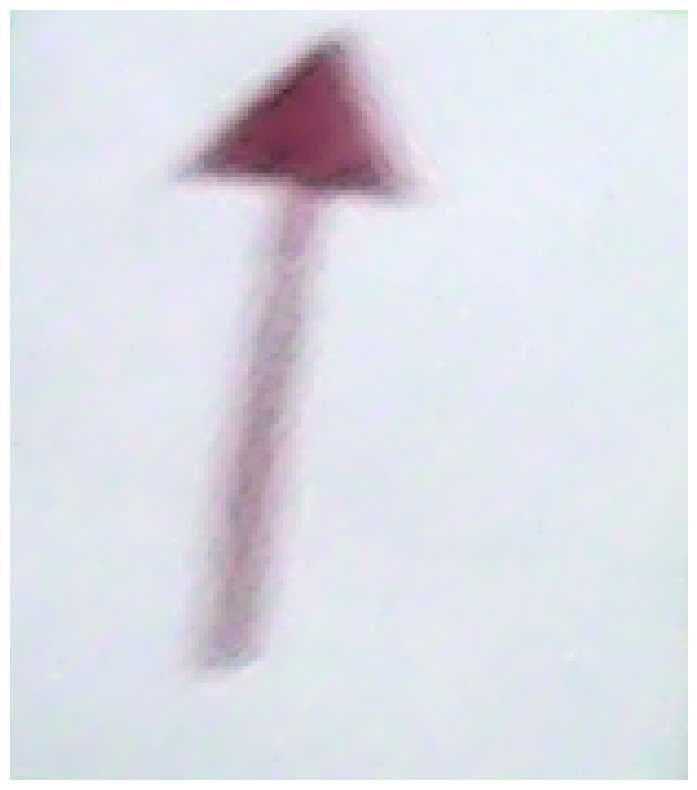

До листочка еще 95.90027112104983
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


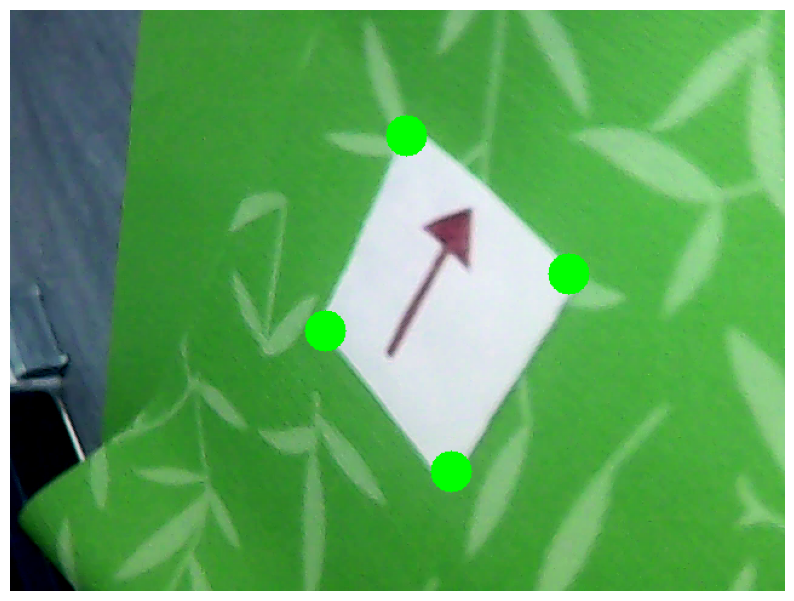

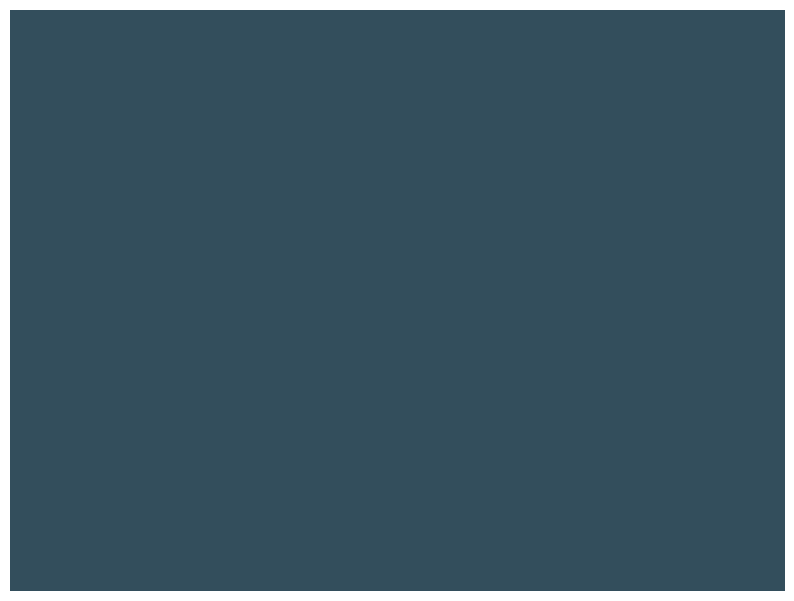

До листочка еще 94.16636278762623
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


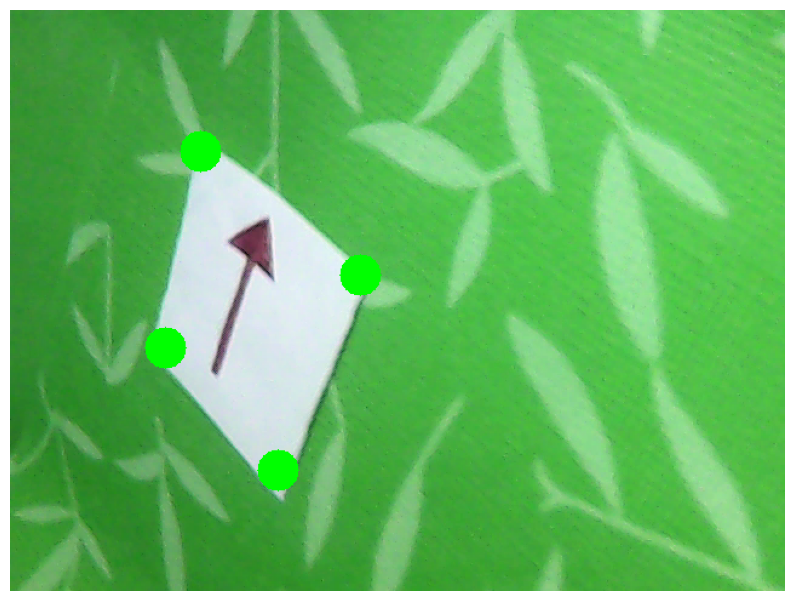

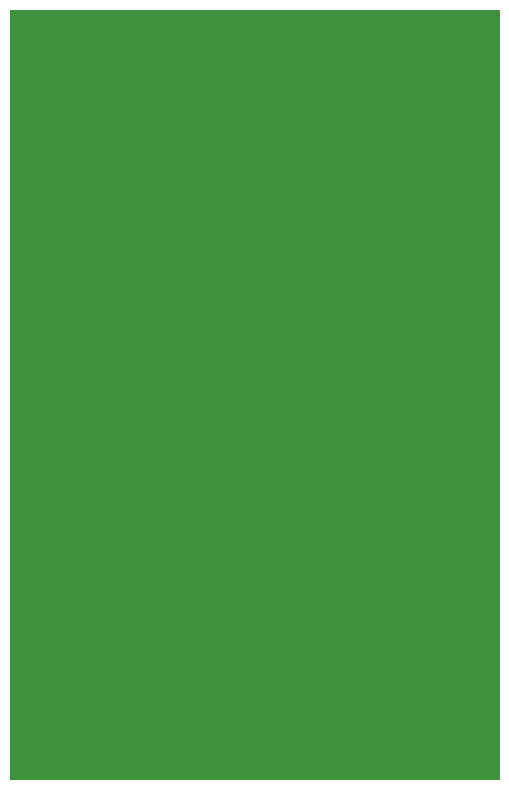

До листочка еще 101.82465988105734
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


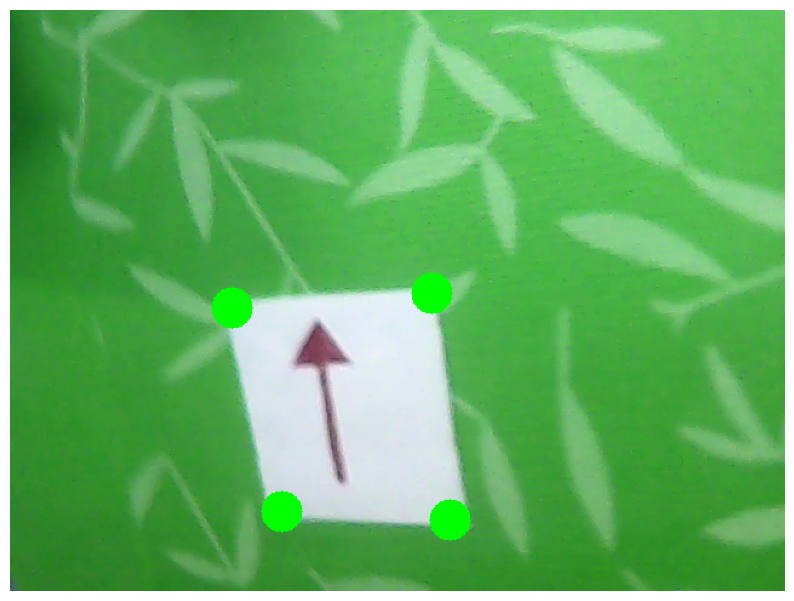

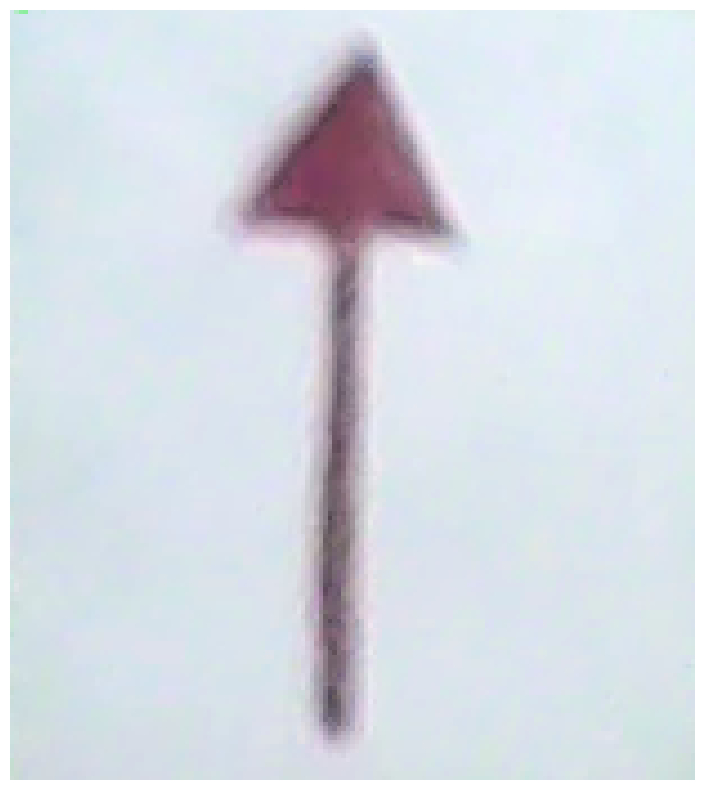

До листочка еще 98.50510331015758
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


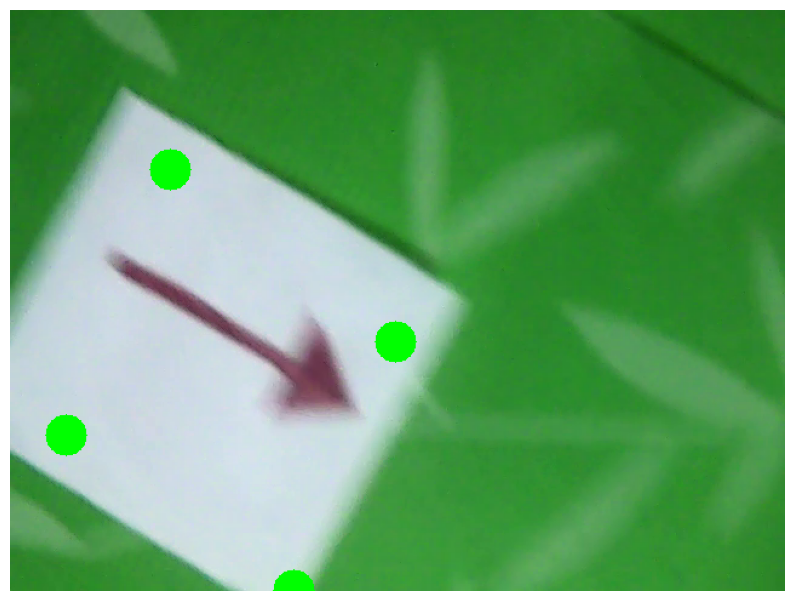

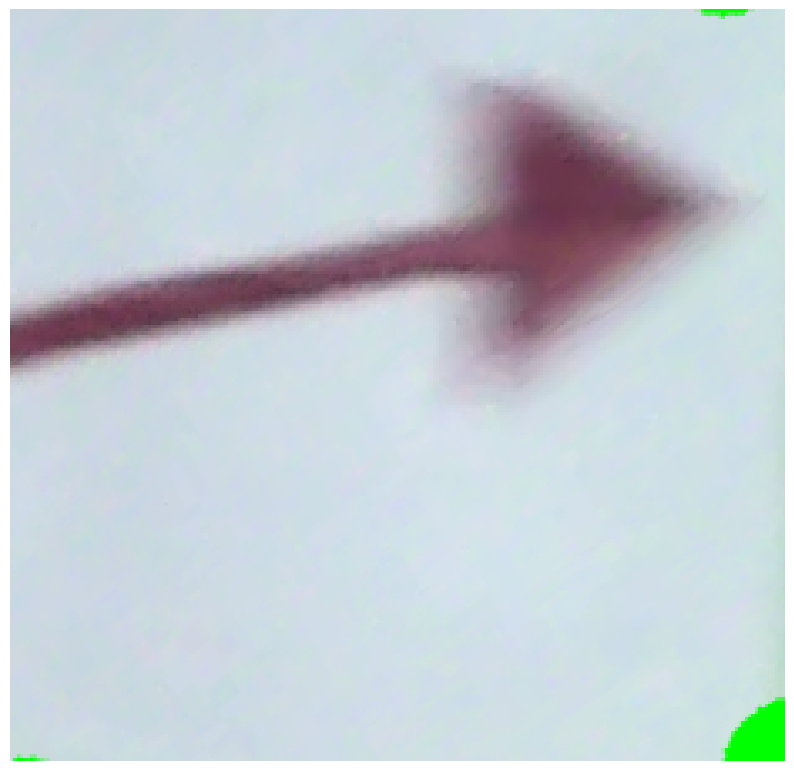

До листочка еще 71.35160561682362
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


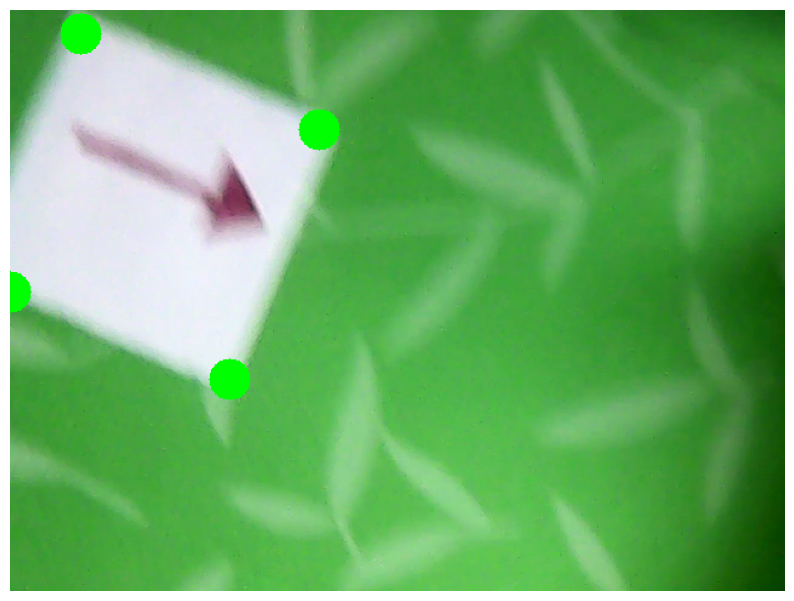

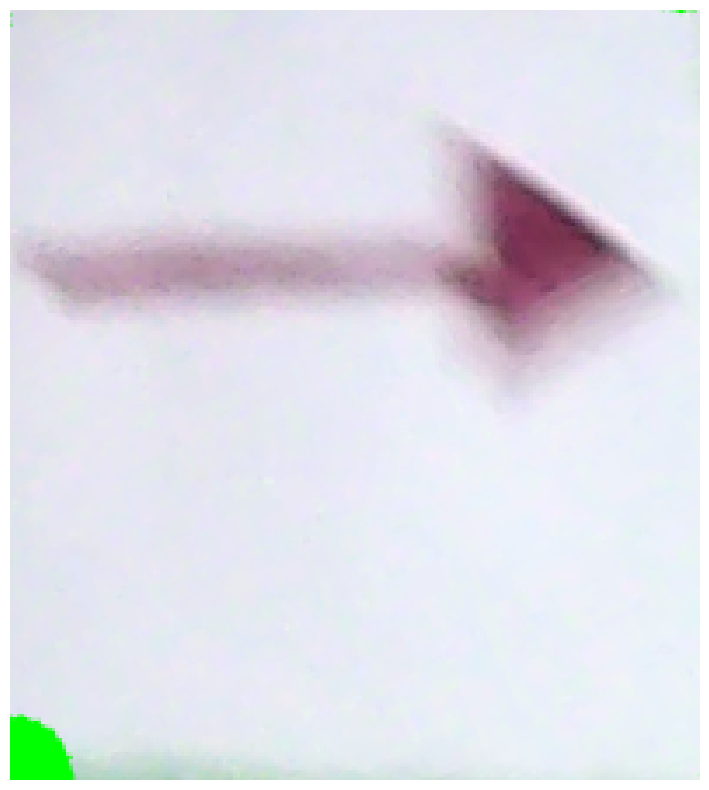

До листочка еще 77.38385569926486
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________


In [ ]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import time
import os
import math
import sys


images = glob.glob('/Users/dududugin/Desktop/CVR23/arrow/*.png')

def find_contour (img, low_th, high_th):
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange (img, low_th, high_th)
    
    morp_k_sz = 1
    
    opening_ker = np.ones((morp_k_sz + 10, morp_k_sz + 10), np.uint8)
    closing_ker = np.ones((morp_k_sz + 34, morp_k_sz + 34), np.uint8)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, opening_ker)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, closing_ker)
    
    #находим конуры и выбираем только внешние
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours [0]
    
    #строим выпуклую оболочку контура
    approx = cv2.convexHull (cnt)
    

    
    #апроксимируем контур с помощью алгоритма 
    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    
    return approx

def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    contour_marked = cv2.drawContours(img, contour, -1, (0, 255, 0), 33)
    plt.imshow (contour_marked)
    plt.axis ('off')
    plt.show ()
    
    length = cv2.arcLength (contour, True)
    

    distance = 180.0 * 364 / length
    #не понял формулу
    
    return distance

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    rect = np.zeros((4, 2), dtype="float32")

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference

    s = pts.sum(axis=1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    pts_sort = [r for i, r in enumerate(pts) if i != np.argmin(s) and i != np.argmax(s)]

    diff = np.diff(pts, axis=1)

    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    res= f'''До листочка еще {find_distance (img)}
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________
    ____________________________________________________________________'''
    
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)
    
    warped = four_point_transform (img, np.asarray (find_contour (img, low_th, high_th)) [:, 0, :])
                                   
    plt.imshow (warped)
    plt.axis ('off')
    plt.show ()
    
    print(res)
    #cv2.waitKey(500)

cv2.destroyAllWindows()


## Трейдинговый софт, который показывает направление курса биткоина

наклон =  -0.04410751206064778  градусы =  -2.525537346785331


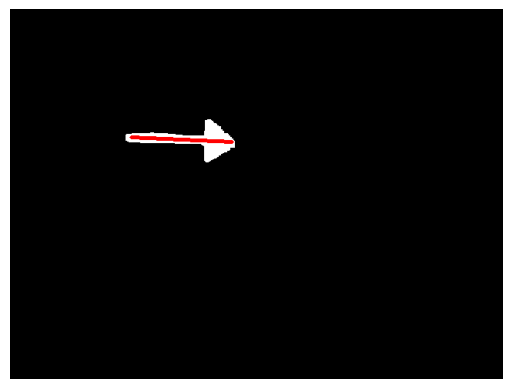

наклон =  -0.6347666491872053  градусы =  -32.406018260328096


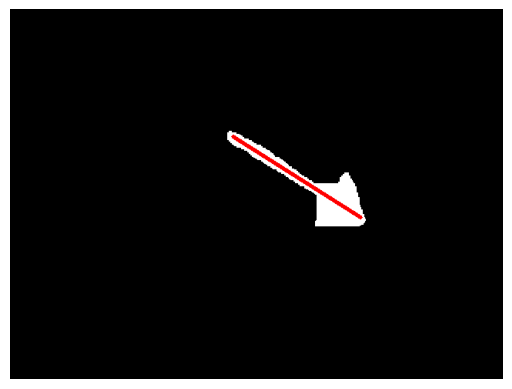

наклон =  0.1814692982456141  градусы =  10.285495390828098


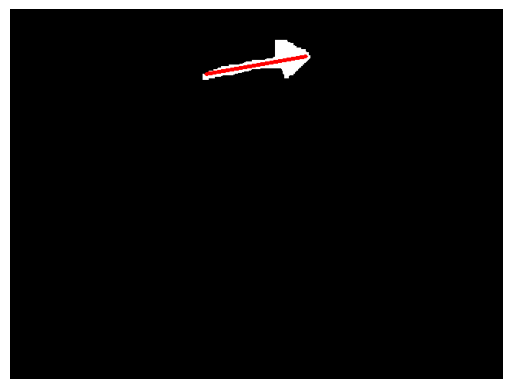

наклон =  2.7625508819538678  градусы =  70.10054019274168


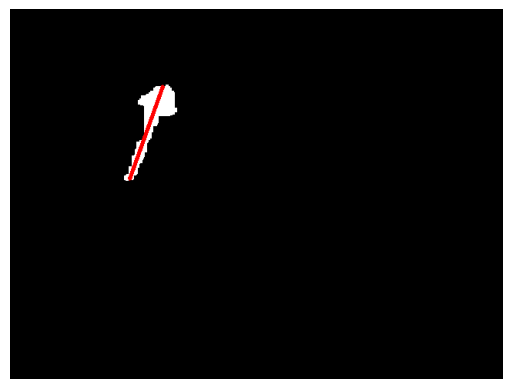

наклон =  1.3304130162703376  градусы =  53.069781958846306


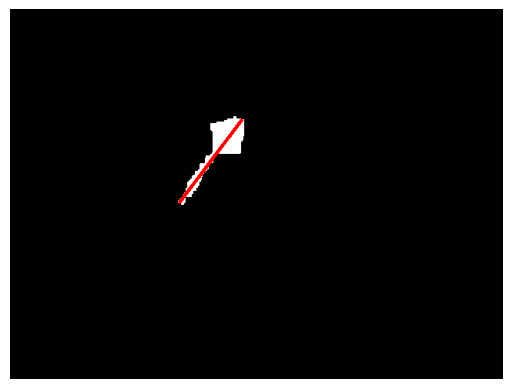

наклон =  1.8936170212765966  градусы =  62.16191880286531


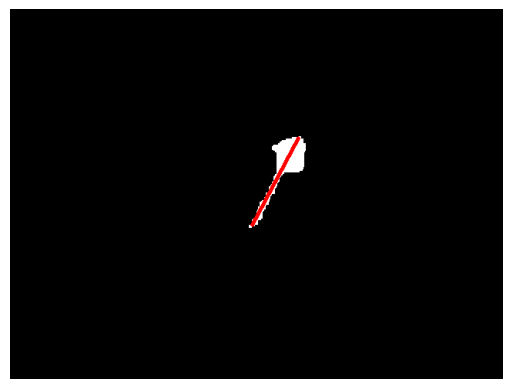

наклон =  2.92  градусы =  71.09542415738835


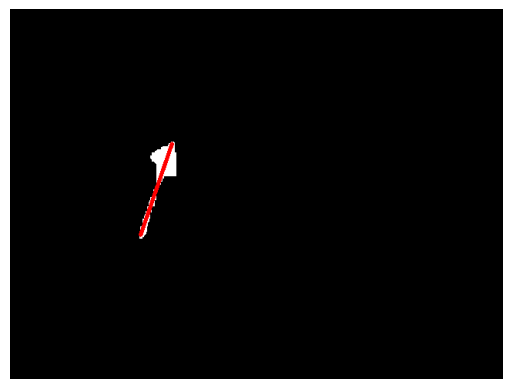

наклон =  -8.353333333333333  градусы =  -83.17345513187978


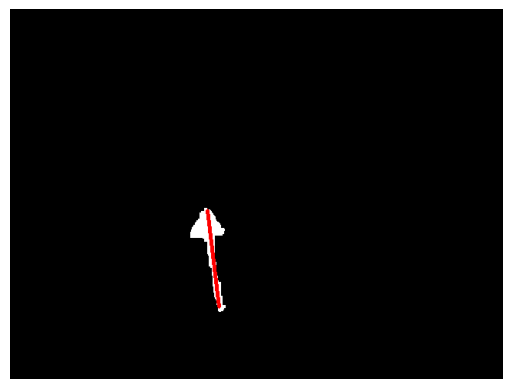

наклон =  -0.6259063296100333  градусы =  -32.04271010074939


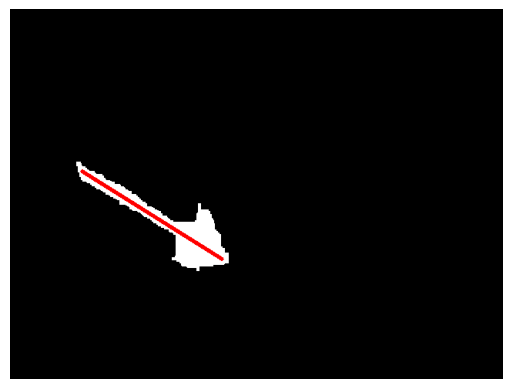

наклон =  -0.5166145981255325  градусы =  -27.321536524850867


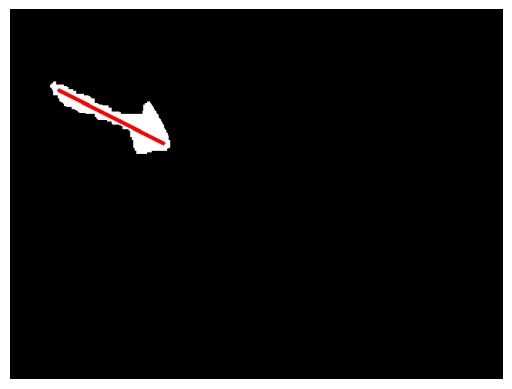

In [ ]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import time
import os
import math
import sys


images = glob.glob('/Users/dududugin/Desktop/CVR23/arrow/*.png')

for frame in images:
    lth, hth = (100, 18, 50), (180, 255, 230)
    img = cv2.imread(frame)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lth, hth)
    
    morp_k_sz = 2
    opening_ker = np.ones((morp_k_sz + 1, morp_k_sz + 1), np.uint8)
    
    closing_ker = np.ones((morp_k_sz + 25, morp_k_sz + 25), np.uint8)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, opening_ker)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, closing_ker)
    
    # преобразование маски в массив точек
    #points = np.transpose(np.nonzero(mask))

        # применение порогового преобразования для получения бинарного изображения
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

    # поиск линий на бинарном изображении
    lines = cv2.HoughLinesP(binary_mask, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=800)

    # вывод найденных линий на маску
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    x1, y1, x2, y2 = [0, 0, 0, 0]
    N = 1
    #усредняю линии
    for line in lines:
        x1 = (line[0][0] + x1)
        y1 = (line[0][1] + y1)
        x2 = (line[0][2] + x2)
        y2 = (line[0][3] + y2)
        N+=1
    x1 /= (N-1)
    y1 /= (N-1)
    x2 /= (N-1)
    y2 /= (N-1)
    cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
    '''for line in lines:
        x1, y1, x2, y2 = line[0]
        print('2', x1)
        cv2.line(mask, (x1, y1), (x2, y2), (255, 0, 0), 3)'''

    # вычисление наклона прямой
    slope = (y1-y2)/(x2-x1) 
    gradusi = np.arctan((y1-y2)/(x2-x1))*180/np.pi 
    print('наклон = ', slope, ' градусы = ', gradusi)

    # вывод маски с найденными линиями
    plt.axis ('off')
    plt.imshow (mask)
    plt.show ()
    
    '''                              
    #plt.imshow (hsv[:, :, 0])
    plt.axis ('off')
    #plt.show ()
    plt.imshow (mask)
    plt.show ()
    #cv2.waitKey(500)
    # вычисляем гистограмму в пространстве HSV для каналов H, S и V
    hist_h = cv2.calcHist([hsv], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [256], [0, 256])
    # выводим гистограммы
    plt.subplot(131), plt.plot(hist_h), plt.title('Hue')
    plt.subplot(132), plt.plot(hist_s), plt.title('Saturation')
    plt.subplot(133), plt.plot(hist_v), plt.title('Value')
    plt.show()'''

cv2.destroyAllWindows()


## Жесткое гей порно скачать онлайн бесплатно

In [ ]:
import numpy as np
import cv2
video_name = "/Users/dududugin/Desktop/CVR23/3.mov"

cam = cv2.VideoCapture(video_name)
while(True):
    success, frame = cam.read()
    
    if (success == False):
        print("reading failed")

        cam.release()

        cam = cv2.VideoCapture(video_name)
        
        continue
    lth, hth = (100, 18, 50), (180, 255, 230)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lth, hth)
    
    morp_k_sz = 2
    opening_ker = np.ones((morp_k_sz + 1, morp_k_sz + 1), np.uint8)
    
    closing_ker = np.ones((morp_k_sz + 25, morp_k_sz + 25), np.uint8)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, opening_ker)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, closing_ker)
    
    # преобразование маски в массив точек
    #points = np.transpose(np.nonzero(mask))

        # применение порогового преобразования для получения бинарного изображения
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

    # поиск линий на бинарном изображении
    lines = cv2.HoughLinesP(binary_mask, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=800)

    # вывод найденных линий на маску
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    x1, y1, x2, y2 = [0, 0, 0, 0]
    N = 1
    #усредняю линии
    for line in lines:
        x1 = (line[0][0] + x1)
        y1 = (line[0][1] + y1)
        x2 = (line[0][2] + x2)
        y2 = (line[0][3] + y2)
        N+=1
    x1 /= (N-1)
    y1 /= (N-1)
    x2 /= (N-1)
    y2 /= (N-1)
    cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
    '''for line in lines:
        x1, y1, x2, y2 = line[0]
        print('2', x1)
        cv2.line(mask, (x1, y1), (x2, y2), (255, 0, 0), 3)'''

    # вычисление наклона прямой
    slope = (y1-y2)/(x2-x1) 
    gradusi = np.arctan((y1-y2)/(x2-x1))*180/np.pi 
    #print('наклон = ', slope, ' градусы = ', gradusi)
    
    cv2.imshow("frame", mask)
    #cv2.imshow("closed", closed)
    
    key = cv2.waitKey(140) & 0xFF
    
    if (key == ord('q')):
        break

cam.release()
cv2.destroyAllWindows()
cv2.waitKey(10)